In [1]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta, date
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
import statsmodels.api as sm

import sys
import os.path as osp

SRC_SUBDIR = '../src/'
SRC_SUBDIR = osp.abspath(SRC_SUBDIR)
if SRC_SUBDIR not in sys.path:
    sys.path.insert(1, SRC_SUBDIR)
    
from load_data import LoadData
from clean_data import CleanData

In [2]:
data_location = '/raw/'
export_date = '2025-03-01'
load_data = LoadData(data_location, export_date)

### Response variables

In [3]:
mood_data = load_data.load_mood_data()
mood_data.head()

,dt,mood_type,value,updated_time
0,"Sat, 6 May 2023 14:00:58",feeling,4,"Sat, 6 May 2023 14:00:58"
1,"Sun, 11 Feb 2024 04:06:37",satisfaction,4,"Sun, 11 Feb 2024 04:06:37"
2,"Wed, 2 Nov 2022 09:04:11",motivation,3,"Wed, 2 Nov 2022 09:04:11"
3,"Wed, 12 Jul 2023 19:02:37",feeling,3,"Wed, 12 Jul 2023 19:02:37"
4,"Sat, 1 Mar 2025 13:39:47",motivation,2,"Sat, 1 Mar 2025 13:39:47"


In [4]:
clean_data = CleanData()

In [5]:
mood_df = clean_data.clean_mood_data(mood_data)

In [6]:
mood_df.head()

,Record_Date,average_feeling,satisfaction,motivation
0,2022-10-26,3.000000,3.0,3.0
1,2022-10-27,2.833333,2.0,4.0
2,2022-10-28,3.125000,4.0,2.0
3,2022-10-29,3.375000,3.0,3.0
4,2022-10-30,3.571429,4.0,4.0


### Feelings

In [7]:
avg_feelings_df = mood_df[['Record_Date','average_feeling']]
avg_feelings_df = avg_feelings_df.rename(columns={'average_feeling':'value'})
avg_feelings_df.head()

,Record_Date,value
0,2022-10-26,3.000000
1,2022-10-27,2.833333
2,2022-10-28,3.125000
3,2022-10-29,3.375000
4,2022-10-30,3.571429


### Explanatory variables

In [8]:
exvar_data = load_data.load_activity_data()
exvar_data.head()

,dt,bullet_type,text,score,is_processed,bullet_status,preferred_emoji_char,completed_time,creation_time,position,...,linked_action_config.bullet.targeting_power_up_uuids,linked_action_config.bullet.associated_power_up_uuids,linked_action_config.bullet.linked_action_config,preferred_area_names,action_name,story_id,is_persistent,preferred_sentiment,gift_ids,linked_community_habit_id
0,"Sun, 28 Apr 2024 01:00:00",1,#Meditation Timer,0.000000,True,0.0,🧘🏾,,"Sun, 28 Apr 2024 08:50:29",7.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,"Thu, 11 Apr 2024 01:00:00",1,Think about a positive moment with #yoga,6.666667,True,0.0,NaN,,"Thu, 11 Apr 2024 09:01:23",0.0,...,[],[],NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,"Fri, 17 May 2024 01:00:00",1,#Yoga,0.000000,True,0.0,NaN,,"Fri, 17 May 2024 10:26:16",3.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,"Sun, 28 Jan 2024 01:00:00",1,Think about a positive moment with #yoga,6.666667,True,0.0,NaN,,"Sun, 28 Jan 2024 07:45:41",0.0,...,[],[],NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,"Tue, 5 Sep 2023 01:00:00",1,#Read for #fun,6.666667,True,1.0,NaN,"Tue, 5 Sep 2023 14:56:34","Tue, 5 Sep 2023 10:16:36",8.0,...,NaN,NaN,NaN,[],NaN,NaN,NaN,NaN,NaN,NaN


In [9]:
exvar_df = clean_data.clean_activity_data(exvar_data)

In [10]:
exvar_df.head()

,Record_Date,text,bullet_status
0,2024-04-28,Meditation,0.0
1,2024-04-11,Think about a positive moment with yoga,0.0
2,2024-05-17,Yoga,0.0
3,2024-01-28,Think about a positive moment with yoga,0.0
4,2023-09-05,Read for fun,1.0


In [11]:
exvar_df = exvar_df.sort_values('Record_Date',ascending=False)
exvar_df.head()

,Record_Date,text,bullet_status
10684,2025-03-01,Apply to 1 Job,0.0
5820,2025-03-01,Think about a positive moment with yoga,0.0
6729,2025-03-01,Remind myself of the challenges I've overcome ...,0.0
13418,2025-03-01,Create a dedicated workspace to draw better bo...,0.0
11989,2025-03-01,Just be,1.0


In [12]:
completed_variables_df = exvar_df.query("bullet_status == 1.0").drop(['bullet_status'],axis=1)
completed_variables_df = completed_variables_df.rename(columns={'text':'variable'})
completed_variables_df.head()

,Record_Date,variable
11989,2025-03-01,Just be
5652,2025-03-01,Eat breakfast
7609,2025-03-01,Read for fun
2804,2025-03-01,Take meds
10732,2025-03-01,Take Vitamin_D


In [13]:
completed_variables_df.shape

(6817, 2)

In [14]:
# try smaller amount of variables for now, using the most commonly completed (which could be an issue?)
num_variables = 20
top_ex_variables = completed_variables_df.groupby('variable').count().sort_values('Record_Date', ascending=False).head(num_variables).index.to_list()

In [15]:
top_ex_variables

['Drink water',
 'Just be',
 'Put away one item that is not in its place',
 'Eat breakfast',
 'Eat lunch',
 'Eat Dinner',
 'Meditation',
 'Mindfulness Walk',
 'Read for fun',
 '7000 steps',
 'Take a shower',
 'Step outside once',
 'Yoga',
 'Take meds',
 'Start a load of laundry',
 'Take Vitamin_D',
 'Gratitude Jar',
 'Do 1 Job Hunt Related Task',
 'Take Vitamin_C',
 'Make art 🎨']

In [16]:
# choose from these top 20 the activities that I suspect have a big influence on my mood
ex_variables = [
    'Eat breakfast',
    'Eat lunch',
    'Eat Dinner',
    'Meditation',
    'Mindfulness Walk',
    'Read for fun',
    '7000 steps',
    'Take a shower',
    'Step outside once',
    'Yoga',
    'Gratitude Jar',
]

In [17]:
# clean variables/column names a bit
ex_var_dict = {}
for var in ex_variables:
    ex_var_dict[var] = string.capwords(var)

In [18]:
completed_var_limit_df = completed_variables_df[completed_variables_df['variable'].isin(ex_variables)]
completed_encoded_exvar_df = pd.get_dummies(completed_var_limit_df.variable).join(completed_var_limit_df).drop('variable',axis=1)
completed_encoded_exvar_df = completed_encoded_exvar_df.rename(columns=ex_var_dict)
completed_encoded_exvar_df.head()

,7000 Steps,Eat Dinner,Eat Breakfast,Eat Lunch,Gratitude Jar,Meditation,Mindfulness Walk,Read For Fun,Step Outside Once,Take A Shower,Yoga,Record_Date
5652,False,False,True,False,False,False,False,False,False,False,False,2025-03-01
7609,False,False,False,False,False,False,False,True,False,False,False,2025-03-01
2582,False,False,True,False,False,False,False,False,False,False,False,2025-02-28
12651,False,False,False,False,False,False,False,False,True,False,False,2025-02-28
5454,False,False,False,True,False,False,False,False,False,False,False,2025-02-28


In [19]:
exvar_encoded_df = completed_encoded_exvar_df.groupby('Record_Date').any()
exvar_encoded_df.head()

,7000 Steps,Eat Dinner,Eat Breakfast,Eat Lunch,Gratitude Jar,Meditation,Mindfulness Walk,Read For Fun,Step Outside Once,Take A Shower,Yoga
Record_Date,,,,,,,,,,,
2022-10-27,False,False,False,False,True,False,False,False,False,False,False
2022-10-31,True,False,False,False,False,False,False,False,False,False,False
2022-11-01,True,False,False,False,False,True,False,False,False,False,False
2022-11-02,False,False,False,False,False,True,False,False,False,False,False
2022-11-03,True,False,False,False,False,True,False,False,False,False,False


In [20]:
for col in exvar_encoded_df.columns.to_list():
    exvar_encoded_df[col] = exvar_encoded_df[col].astype(int)
exvar_encoded_df.head()    

,7000 Steps,Eat Dinner,Eat Breakfast,Eat Lunch,Gratitude Jar,Meditation,Mindfulness Walk,Read For Fun,Step Outside Once,Take A Shower,Yoga
Record_Date,,,,,,,,,,,
2022-10-27,0,0,0,0,1,0,0,0,0,0,0
2022-10-31,1,0,0,0,0,0,0,0,0,0,0
2022-11-01,1,0,0,0,0,1,0,0,0,0,0
2022-11-02,0,0,0,0,0,1,0,0,0,0,0
2022-11-03,1,0,0,0,0,1,0,0,0,0,0


### adding composite feature: mindfulness

In [21]:
exvar_encoded_df['Mindfulness'] = exvar_encoded_df[['Meditation', 'Mindfulness Walk', 'Yoga']].any(axis=1).astype(int)
exvar_encoded_df.head()

,7000 Steps,Eat Dinner,Eat Breakfast,Eat Lunch,Gratitude Jar,Meditation,Mindfulness Walk,Read For Fun,Step Outside Once,Take A Shower,Yoga,Mindfulness
Record_Date,,,,,,,,,,,,
2022-10-27,0,0,0,0,1,0,0,0,0,0,0,0
2022-10-31,1,0,0,0,0,0,0,0,0,0,0,0
2022-11-01,1,0,0,0,0,1,0,0,0,0,0,1
2022-11-02,0,0,0,0,0,1,0,0,0,0,0,1
2022-11-03,1,0,0,0,0,1,0,0,0,0,0,1


### Meditation vs Mood

In [22]:
exvar_encoded_df = exvar_encoded_df.sort_values('Record_Date')
exvar_encoded_df.head()

,7000 Steps,Eat Dinner,Eat Breakfast,Eat Lunch,Gratitude Jar,Meditation,Mindfulness Walk,Read For Fun,Step Outside Once,Take A Shower,Yoga,Mindfulness
Record_Date,,,,,,,,,,,,
2022-10-27,0,0,0,0,1,0,0,0,0,0,0,0
2022-10-31,1,0,0,0,0,0,0,0,0,0,0,0
2022-11-01,1,0,0,0,0,1,0,0,0,0,0,1
2022-11-02,0,0,0,0,0,1,0,0,0,0,0,1
2022-11-03,1,0,0,0,0,1,0,0,0,0,0,1


In [23]:
all_days = pd.date_range(start=exvar_encoded_df.index.min(), end=exvar_encoded_df.index.max(), freq='D')

In [24]:
exvar_encoded_df = exvar_encoded_df.reindex(all_days)

In [25]:
exvar_encoded_df.head()

,7000 Steps,Eat Dinner,Eat Breakfast,Eat Lunch,Gratitude Jar,Meditation,Mindfulness Walk,Read For Fun,Step Outside Once,Take A Shower,Yoga,Mindfulness
2022-10-27,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2022-10-28,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-10-29,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-10-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-10-31,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [26]:
avg_feelings_df = avg_feelings_df.set_index('Record_Date')

In [27]:
feeling_min_date = avg_feelings_df.index.min()
feeling_max_date = avg_feelings_df.index.max()

In [28]:
exvar_min_date = exvar_encoded_df.index.min()
exvar_max_date = exvar_encoded_df.index.max()

In [29]:
min_date = max(feeling_min_date,exvar_min_date)
max_date = min(feeling_max_date,exvar_max_date)

In [30]:
avg_feelings_df = avg_feelings_df[(avg_feelings_df.index > min_date) & (avg_feelings_df.index < max_date)]
exvar_encoded_df = exvar_encoded_df[(exvar_encoded_df.index > min_date) & (exvar_encoded_df.index < max_date)]

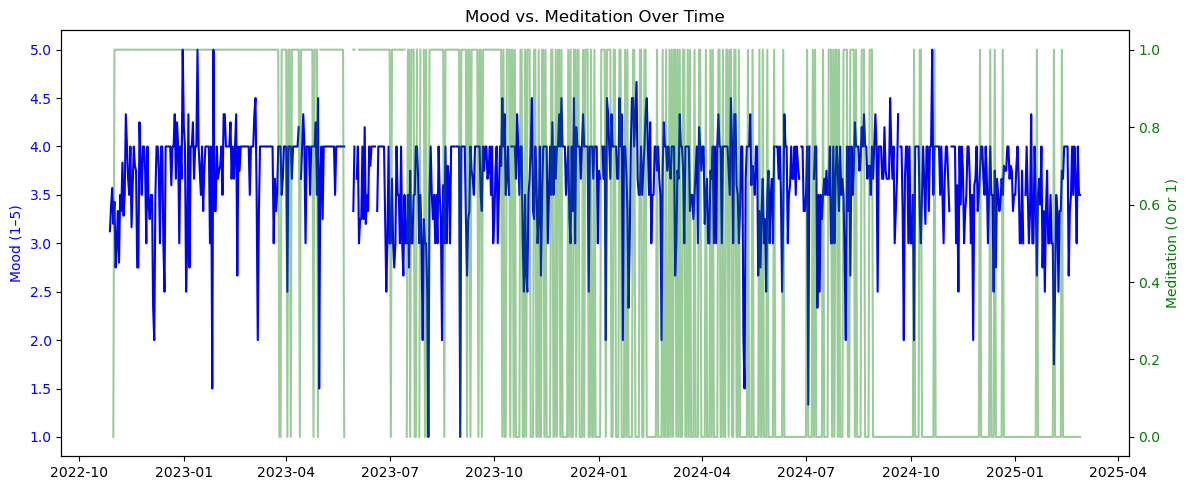

In [31]:
# Plot
fig, ax1 = plt.subplots(figsize=(12, 5))

# Mood
ax1.plot(avg_feelings_df.index, avg_feelings_df['value'], label='Mood (7-day Avg)', color='blue')
ax1.set_ylabel('Mood (1–5)', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

# Meditation (right axis)
ax2 = ax1.twinx()
ax2.plot(exvar_encoded_df.index, exvar_encoded_df['Meditation'], label='Meditation', color='green', alpha=0.4)
ax2.set_ylabel('Meditation (0 or 1)', color='green')
ax2.tick_params(axis='y', labelcolor='green')

plt.title('Mood vs. Meditation Over Time')
fig.tight_layout()
plt.show()


### Linear Regression Analysis

In [32]:
features = exvar_encoded_df.columns.to_list()

In [33]:
#for col in features:
#    exvar_encoded_df[col] = pd.to_numeric(exvar_encoded_df[col], errors='coerce')
#exvar_encoded_df.head()    

In [34]:
# introducing 1 day lag, i.e. do yesterday's self care activities influence today's mood?
lagged_1day_features = []
for col in features:
    col_name = f'{col}_lag1'
    exvar_encoded_df[col_name] = exvar_encoded_df[col].shift(1)
    lagged_1day_features.append(col_name)
lagged_1day_features

['7000 Steps_lag1',
 'Eat Dinner_lag1',
 'Eat Breakfast_lag1',
 'Eat Lunch_lag1',
 'Gratitude Jar_lag1',
 'Meditation_lag1',
 'Mindfulness Walk_lag1',
 'Read For Fun_lag1',
 'Step Outside Once_lag1',
 'Take A Shower_lag1',
 'Yoga_lag1',
 'Mindfulness_lag1']

In [35]:
exvar_encoded_df.index.name = 'Record_Date'

In [36]:
df = pd.merge(avg_feelings_df.reset_index(), exvar_encoded_df[lagged_1day_features].reset_index(), on='Record_Date', how='inner')

In [37]:
df.head()

,Record_Date,value,7000 Steps_lag1,Eat Dinner_lag1,Eat Breakfast_lag1,Eat Lunch_lag1,Gratitude Jar_lag1,Meditation_lag1,Mindfulness Walk_lag1,Read For Fun_lag1,Step Outside Once_lag1,Take A Shower_lag1,Yoga_lag1,Mindfulness_lag1
0,2022-10-28,3.125000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2022-10-29,3.375000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2022-10-30,3.571429,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2022-10-31,3.200000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2022-11-01,3.428571,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [38]:
fill_values = {}
for col in lagged_1day_features:
    fill_values[col] = 0
    
df = df.fillna(value=fill_values)
df = df.dropna(subset=['value'])
# assuming that if I'm missing records then I just didn't do that activity

In [39]:
df.head()

,Record_Date,value,7000 Steps_lag1,Eat Dinner_lag1,Eat Breakfast_lag1,Eat Lunch_lag1,Gratitude Jar_lag1,Meditation_lag1,Mindfulness Walk_lag1,Read For Fun_lag1,Step Outside Once_lag1,Take A Shower_lag1,Yoga_lag1,Mindfulness_lag1
0,2022-10-28,3.125000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2022-10-29,3.375000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2022-10-30,3.571429,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2022-10-31,3.200000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2022-11-01,3.428571,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [40]:
X = df[lagged_1day_features]
y = df['value']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [41]:
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

In [42]:
y_pred = model.predict(X_test)
print("R² Score:", r2_score(y_test, y_pred))
print("MSE:", mean_squared_error(y_test, y_pred))

R² Score: 0.026632258667759645
MSE: 0.26293789226910014


In [43]:
# Pair coefficients with feature names
coeff_df = pd.DataFrame({
    'Feature': lagged_1day_features,
    'Coefficient': model.coef_
}).sort_values(by='Coefficient', ascending=False)
coeff_df

,Feature,Coefficient
11,Mindfulness_lag1,0.123681
1,Eat Dinner_lag1,0.116015
8,Step Outside Once_lag1,0.083847
5,Meditation_lag1,0.053970
0,7000 Steps_lag1,0.043180
2,Eat Breakfast_lag1,0.034142
4,Gratitude Jar_lag1,-0.026919
3,Eat Lunch_lag1,-0.031390
6,Mindfulness Walk_lag1,-0.049878
10,Yoga_lag1,-0.063348


So feature Eat Dinner_lag1 has a coefficient of 0.107756
* I.E. Eating dinner yesterday had a positive but marginal effect on today's mood
* It doesn't sound huge, but if a few habits stack up positively (e.g., dinner, meditation, walk), they can have a compounding effect.

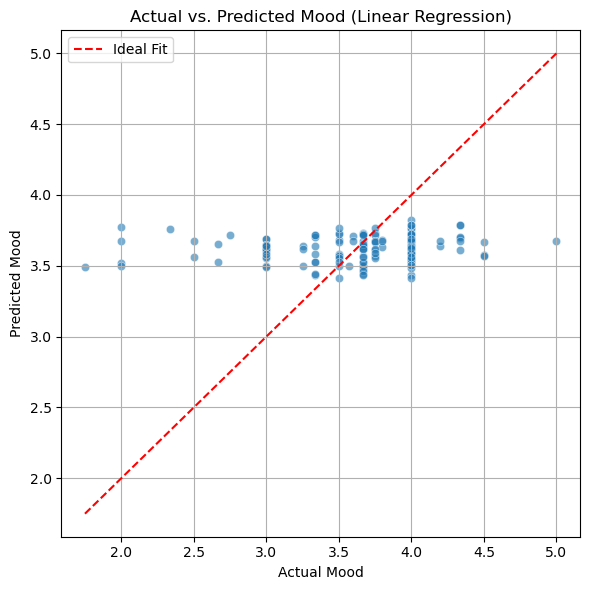

In [44]:
# examine predicted vs acuatal mood for this model

plt.figure(figsize=(6, 6))
sns.scatterplot(x=y_test, y=y_pred, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--', label='Ideal Fit')
plt.xlabel('Actual Mood')
plt.ylabel('Predicted Mood')
plt.title('Actual vs. Predicted Mood (Linear Regression)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [45]:
# Regression model, look at significance
X_with_const = sm.add_constant(X)  # adds intercept term, i.e. baseline mood when I didn’t do any of the activities that day
model = sm.OLS(y, X_with_const).fit()

In [46]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  value   R-squared:                       0.030
Model:                            OLS   Adj. R-squared:                  0.016
Method:                 Least Squares   F-statistic:                     2.102
Date:                Fri, 09 May 2025   Prob (F-statistic):             0.0148
Time:                        13:07:05   Log-Likelihood:                -644.01
No. Observations:                 833   AIC:                             1314.
Df Residuals:                     820   BIC:                             1375.
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                      3.4964      0.068     51.318      0.000       3.363       3.630
7000 Steps_lag1            0.0399      0.043      0.932      0.352      -0.044       0.124
Eat Dinner_lag1            0.0668      0.067      1.000      0.318      -0.064       0.198
Eat Breakfast_lag1         0.0453      0.079      0.570      0.569      -0.111       0.201
Eat Lunch_lag1            -0.0031      0.043     -0.073      0.942      -0.087       0.081
Gratitude Jar_lag1         0.0143      0.075      0.190      0.849      -0.134       0.162
Meditation_lag1            0.0788      0.055      1.440      0.150      -0.029       0.186
Mindfulness Walk_lag1      0.0011      0.071      0.016      0.987      -0.139       0.141
Read For Fun_lag1         -0.1043      0.057     -1.832      0.067      -0.216       0.007
Step Outside Once_lag1     0.0975      0.075      1.306      0.192      -0.049       0.244
Take A Shower_lag1        -0.0707      0.076     -0.933      0.351      -0.219       0.078
Yoga_lag1                 -0.1014      0.050     -2.010      0.045      -0.200      -0.002
Mindfulness_lag1           0.0968      0.077      1.262      0.207      -0.054       0.247
==============================================================================
Omnibus:                      231.590   Durbin-Watson:                   1.736
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              626.314
Skew:                          -1.410   Prob(JB):                    9.95e-137
Kurtosis:                       6.177   Cond. No.                         13.0
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

* Meditation Timer_lag1 and Yoga_lag1 are the most significant features based on these p-values
* meditation makes sense, I would suspect meditation would lead to improved mood over time
* interestingly, yoga_lag1 coincides with a negative influence on mood! (not necesarrily *causing* the lower mood, could be other reasons the day-after-yoga mood is low)

In [47]:
# lets examine mood on day after yoga vs no yoga days
df_box = df[['value', 'Yoga_lag1']].dropna()

#map to labels for nicer x-axis
df_box['Yoga_Yesterday'] = df_box['Yoga_lag1'].map({0: 'No Yoga', 1: 'Yoga'})

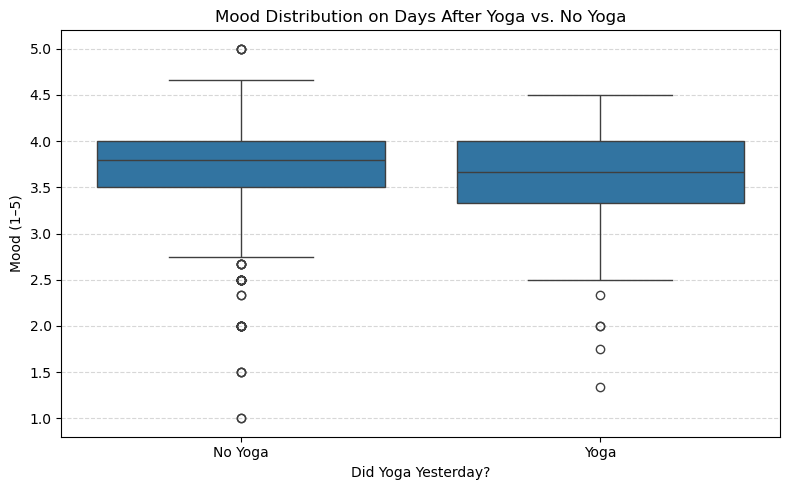

In [48]:
# Plot
plt.figure(figsize=(8, 5))
sns.boxplot(x='Yoga_Yesterday', y='value', data=df_box)
plt.title("Mood Distribution on Days After Yoga vs. No Yoga")
plt.ylabel("Mood (1–5)")
plt.xlabel("Did Yoga Yesterday?")
plt.grid(True, axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

thoughts:
* median mood is very similar for both groups (but aligns with the negative coefficient from the regression model)
* Days after "no yoga" have more variability and outliers, while days after "yoga" have a tighter IQR, suggesting that yoga could influence a more *stable* mood if not a higher one
* it could be helpful in the future to break yoga activity feature into 'restorative yoga' or 'power yoga'; as we know the day after a workout doesn't always feel the best, even if it's generally considered good for you!

### Random Forest Analysis

In [49]:
# Using same X_train, X_test, y_train, y_test as previous model
model_rf = RandomForestRegressor(n_estimators=100, random_state=42)
model_rf.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

In [50]:
importances = model_rf.feature_importances_

# Create a DataFrame for sorting and plotting
imp_df = pd.DataFrame({
    'Feature': lagged_1day_features,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

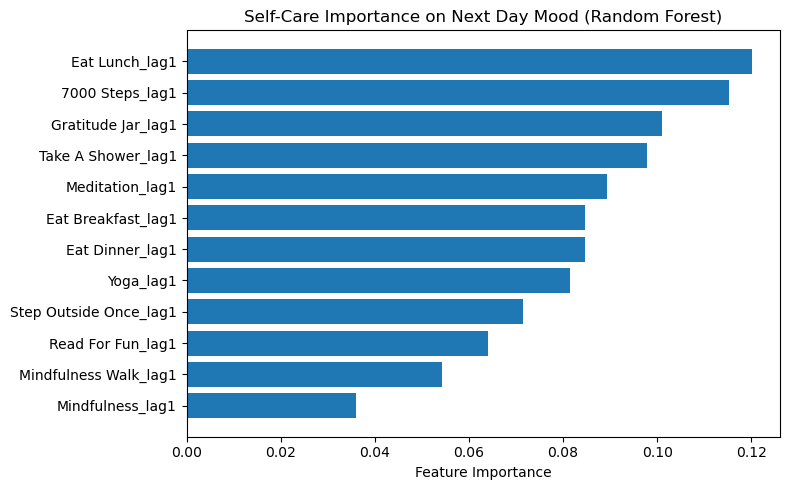

In [51]:
# Plot
plt.figure(figsize=(8, 5))
plt.barh(imp_df['Feature'], imp_df['Importance'])
plt.xlabel('Feature Importance')
plt.title('Self-Care Importance on Next Day Mood (Random Forest)')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

### Feature Selection
* I'm going to go back and reduce features that seem less significant and / or might be highly correlated with other features
* thinking on my selected features, I suspect "Mindfulness Walk" and "Step Outside Once" will be correlated since I usually walk outside!
* Based on the Random Forest model, "Eat Lunch", "7000 Steps", and "Gratitude Jar" are most important
* Based on the Linear Regression model, "Meditation Timer" and "Yoga" are most significant

In [52]:
narrowed_features = [
    '7000 Steps_lag1',
    'Eat Lunch_lag1',
    'Gratitude Jar_lag1',
    'Meditation Timer_lag1',
    'Mindfulness Walk_lag1',
    'Yoga_lag1',
]

#### Linear Regression: Round 2

In [53]:
X_n = df[narrowed_features]
y_n = df['value']
X_n_train, X_n_test, y_n_train, y_n_test = train_test_split(X_n, y_n, test_size=0.2, random_state=42)

KeyError: "['Meditation Timer_lag1'] not in index"

In [ ]:
model_lr_n = LinearRegression()
model_lr_n.fit(X_n_train, y_n_train)

In [ ]:
y_n_pred = model_lr_n.predict(X_n_test)
print("R² Score:", r2_score(y_n_test, y_n_pred))
print("MSE:", mean_squared_error(y_n_test, y_n_pred))

In [ ]:
# Pair coefficients with feature names
coeff_lr_n_df = pd.DataFrame({
    'Feature': narrowed_features,
    'Coefficient': model_lr_n.coef_
}).sort_values(by='Coefficient', ascending=False)
coeff_lr_n_df

In [ ]:
X_with_const_lr_n = sm.add_constant(X_n)  # adds intercept term, i.e. baseline mood when I didn’t do any of the activities that day
model_lr_n_sm = sm.OLS(y_n, X_with_const_lr_n).fit()

In [ ]:
model_lr_n_sm.summary()

### RNN (Recurrent Neural Network) , for fun!

In [ ]:
exvar_encoded_df.index.name = 'Record_Date'
exvar_encoded_df = exvar_encoded_df.reset_index()
exvar_encoded_df.head()

In [ ]:
avg_feelings_df = avg_feelings_df.reset_index()
avg_feelings_df.head()

In [ ]:
# Merge on date
df = pd.merge(avg_feelings_df, exvar_encoded_df, on='Record_Date', how='inner')
df = df.sort_values('Record_Date').reset_index(drop=True)

In [ ]:
df = df.rename(columns={'value': 'mood'})
df['Meditation Timer'] = pd.to_numeric(df['Meditation Timer'], errors='coerce')

In [ ]:
df.dtypes

In [ ]:
SEQUENCE_LENGTH = 7  # Past 7 days

features = ['mood', 'Meditation Timer']
X, y = [], []

for i in range(len(df) - SEQUENCE_LENGTH):
    sequence = df.loc[i:i+SEQUENCE_LENGTH-1, features].values
    target = df.loc[i+SEQUENCE_LENGTH, 'mood']
    
    if not np.isnan(sequence).any() and not np.isnan(target):  # drop NaNs
        X.append(sequence)
        y.append(target)

X = np.array(X)
y = np.array(y)

print("X shape:", X.shape)  # (samples, 7, 2)
print("y shape:", y.shape)  # (samples,)

In [ ]:
from keras.models import Sequential
from keras.layers import SimpleRNN, Dense

# X: shape (samples, time_steps, features)
# y: shape (samples,)
model = Sequential()
model.add(SimpleRNN(32, input_shape=(7, 2), activation='tanh'))  # 7 days, 2 features (mood, meditation)
model.add(Dense(1))  # Output: predicted mood
model.compile(optimizer='adam', loss='mse')
model.fit(X, y, epochs=20, batch_size=16, validation_split=0.2)

In [ ]:
# baseline model with mood only (no meditation)
features = ['mood']
X2, y2 = [], []

for i in range(len(df) - SEQUENCE_LENGTH):
    sequence = df.loc[i:i+SEQUENCE_LENGTH-1, features].values
    target = df.loc[i+SEQUENCE_LENGTH, 'mood']
    
    if not np.isnan(sequence).any() and not np.isnan(target):  # drop NaNs
        X2.append(sequence)
        y2.append(target)

X2 = np.array(X2)
y2 = np.array(y2)

print("X shape:", X2.shape)  # (samples, 7, 2)
print("y shape:", y2.shape)  # (samples,)

In [ ]:
model = Sequential()
model.add(SimpleRNN(32, input_shape=(7, 2), activation='tanh'))  # 7 days, 2 features (mood, meditation)
model.add(Dense(1))  # Output: predicted mood
model.compile(optimizer='adam', loss='mse')
model.fit(X, y, epochs=20, batch_size=16, validation_split=0.2)

#### thoughts
* mood-only model performs almost the same, so meditation might not be adding much predictive value.